In [1]:
library(plyr)
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
library(tidyr)
require(cowplot)
options(repr.plot.width=10, repr.plot.height=8)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Origin=="Tumor")

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    mutate(asEvidence = as.numeric(asEvidence=="True"))

features <- read_tsv("../data/mutations/proteome_features.txt") %>%
    filter(Analysis == "Pfam")

wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,GeneId,Symbol,Patient) %>%
    unique

pf.all <- read_tsv("../results/pfam_enrichment_analysis.tsv")

# convert to upper case the first word
proper=function(x) paste0(toupper(substr(x, 1, 1)), tolower(substring(x, 2)))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
# Figure 1
## Figure 1a
f1a <- switches.split %>%
    filter(Reliable==1) %>%
    mutate(Driver = ifelse(Symbol %in% drivers$Symbol, "1", "0"),
           Driver = ifelse(Driver==1, "Driver", "Non-driver"),
           Driver = factor(Driver, levels=c("Non-driver","Driver")),
           IsFunctional = ifelse(IsFunctional==1, "Functional", "Non-functional")) %>%
    ggplot(aes(x=Tumor, fill=IsFunctional, alpha=Driver)) +
        geom_bar() +
        labs(x="", y="# switches", fill="Switch", alpha="Gene") +
        scale_fill_manual(values=c("Functional"="firebrick", "Non-functional"="gray")) +
        scale_alpha_manual(values=c("Driver"=1, "Non-driver"=0.5)) +
        theme(axis.text.x = element_text(angle = 90))

ggsave("../results/figures/components/1a.png",f1a)

Saving 7 x 7 in image


In [3]:
## Figure 1b
library(UpSetR)

structural <- lapply(cancerTypes, function(tumor){
    paste0("../data/structural_analysis/",tumor,".structural_summary.tsv") %>%
    read_tsv %>%
    set_colnames(c('GeneId','Symbol','Normal_transcript','Tumor_transcript',
                   'ArchDB','Pfam','IUPRED','ANCHOR','ProSite')) %>%
    mutate(ArchDB = ifelse(ArchDB=="True",1,0),
           Pfam = ifelse(Pfam=="True",1,0),
           IUPRED = ifelse(IUPRED=="True",1,0),
           ANCHOR = ifelse(ANCHOR=="True",1,0),
           ProSite = ifelse(ProSite=="True",1,0))
}) %>% do.call("rbind",.) %>%
    unique %>%
    merge(switches)

png("../results/figures/components/1b.png")
f1b <- structural %>%
    select(ArchDB,Pfam,IUPRED,ANCHOR,ProSite) %>%
    # top 20 intersections
    upset(order.by = "freq", nintersects = 10, name.size = 16, line.size = 3, point.size = 8)
dev.off()

Warning message:
: replacing previous import by ‘scales::alpha’ when loading ‘UpSetR’

pdf 
  2

In [4]:
## Figure 1c
bp <- read_tsv("../results/pfam_go_term/losses_GO_biological_process.tsv",skip=15) %>%
    mutate(type="Biological process")
cc <- read_tsv("../results/pfam_go_term/losses_GO_cellular_component.tsv",skip=15) %>%
    mutate(type="Cellular component")
mf <- read_tsv("../results/pfam_go_term/losses_GO_molecular_function.tsv",skip=15) %>%
    mutate(type="Molecular function")

go <- do.call("rbind",list(bp,cc,mf))  %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","type")) %>%
    mutate(goterm = proper(goterm),
           numSwitches = table %>% strsplit("|", fixed=T) %>% 
               lapply(function(x) as.numeric(x[1])) %>% unlist ) %>%
    arrange(desc(numSwitches)) %>%
    filter(slim_level == 2) %>%
    top_n(15) %>%
    mutate(# break lines longer than 40 chr
           # goterm = lapply(goterm, strwrap, width = 40)  %>% lapply(paste,sep="\n", collapse="\n") %>% unlist,
           goterm = factor(goterm, levels=goterm))
                   
f1c <- ggplot(go, aes(x = 1, y = goterm, alpha = numSwitches, fill = type, label = numSwitches)) +
        geom_tile() +
        geom_text(aes(x = 1, y = goterm, label = numSwitches), inherit.aes = F) +
        labs(x = "# switches", y = "GO term", fill = "GO Ontology") +
        theme_classic() +
        theme(axis.text.y = element_text(size = 10), axis.text.x = element_blank(), legend.position="none") +
        scale_alpha_continuous(guide=F) +
        scale_x_discrete(breaks=NULL)

ggsave("../results/figures/components/1c.png",f1c)

Selecting by numSwitches
Saving 7 x 7 in image


In [5]:
## Figure 1d
top.drivers <- switches %>%
    filter(Driver==1 & IsFunctional==1) %>%
    arrange(desc(PatientNumber)) %>%
    top_n(20, PatientNumber) %>%
    mutate(label = paste0(Symbol," (",Normal_transcript,",",Tumor_transcript,")")) %>%
    select(Normal_transcript,Tumor_transcript,label,Symbol)

f1d <- merge(top.drivers, switches.split) %>%
    mutate(label = factor(label, levels=top.drivers$label),
           Symbol = factor(Symbol, levels=top.drivers$Symbol)) %>%
    ggplot(aes(x=Symbol, y=PatientNumber, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="# patients") +
        scale_fill_manual(values=colorPalette) +
        theme(axis.text.x = element_text(angle = 90))

ggsave("../results/figures/components/1d.png",f1d)

Saving 7 x 7 in image


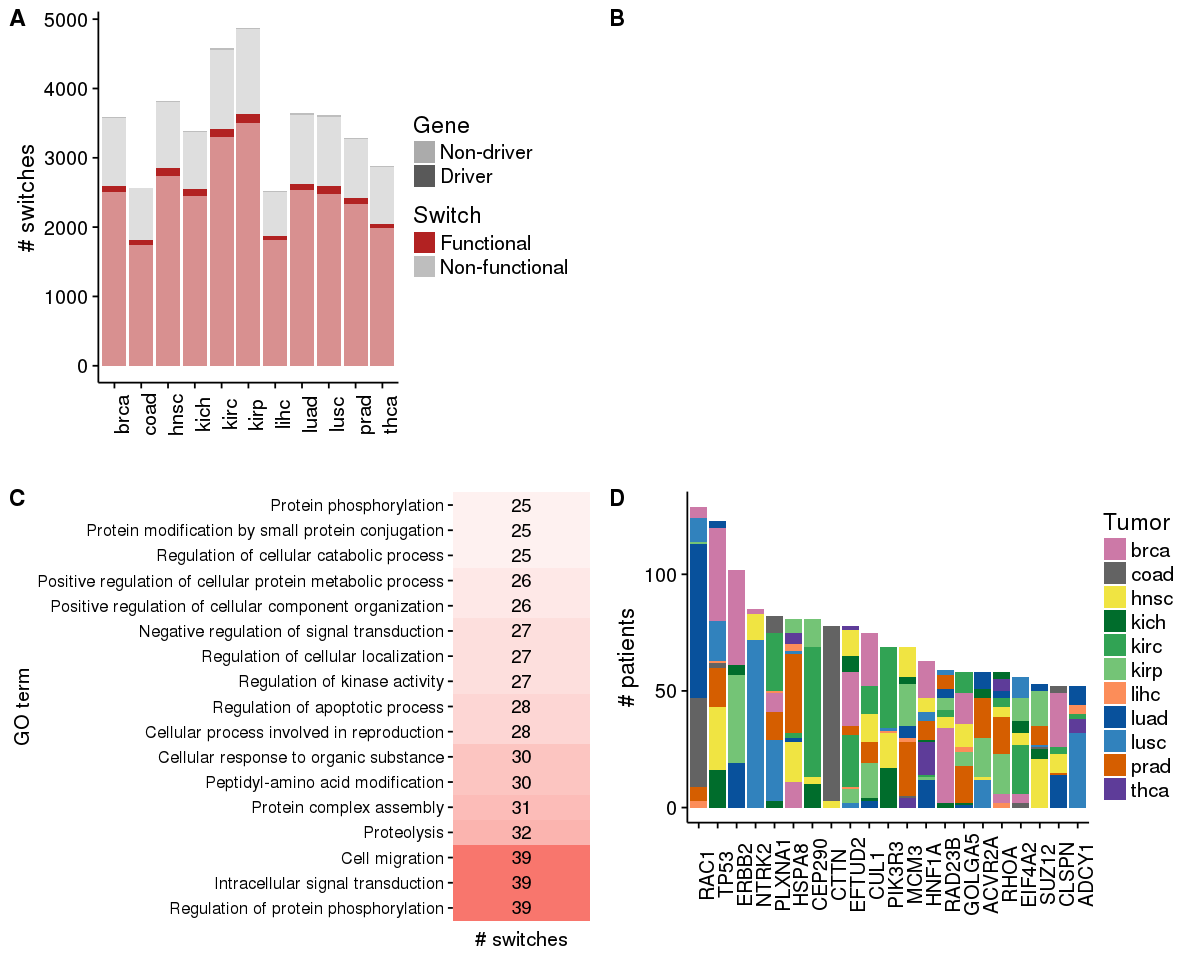

In [6]:
f1 <- plot_grid(f1a, f1b, f1c, f1d, labels=c("A","B","C","D"))
f1
ggsave("../results/figures/figure_1.png",f1, width = 10, height = 8)

Figure 1. (A) Number of switches (y axis) calculated in each tumor type (x axis), separated according to whether the switches are functional or not and whether they affect mutational drivers. The number of non-functional switches in drivers is very low in most tumor types. (B) Overlap graph of protein features affected in functional switches. (C) Functional categories associated to protein domain losses significantly enriched in functional isoform switches. For each functional category we give the number of isoform switches in which a protein domain related to this category is lost. (D) Top 50 functional switches in mutational cancer drivers according to the number of patients in which they occur. We indicate in color the tumor type. 

In [7]:
# Figure 2
## Figure 2a

library(scales)

# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

# show lack of correlation between mutations and switches
f2a <- recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
        geom_point(aes(color=Tumor)) + 
        scale_color_manual(values=colorPalette) + 
        labs(x="Genes with a functional switch", y="Genes with a PAM") +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)

ggsave("../results/figures/components/2a.png",f2a)


Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Saving 7 x 7 in image
Warning message:
: Removed 179 rows containing missing values (geom_point).

In [8]:
## Figure 2b
MS.pfams <- pf.all %>%
    filter((adjp_g < 0.05 | adjp_l < 0.05) & adjp_m < 0.05) %>%
    select(Feature, switches_g, switches_l) %>%
    mutate(Feature = unlist(strsplit(Feature,"|", fixed=T))[c(F,T)],
           Feature = gsub("_"," ",Feature)) %>%
    reshape2::melt(id.vars = "Feature") %>%
    set_colnames(c("Feature","What","NumSwitches")) %>%
    filter(NumSwitches != 0) %>%
    mutate(What = ifelse(What=="switches_l", "Lost", "Gained"),
           What = factor(What, levels=c("Lost","Gained")))

f2b <- MS.pfams %>%
    mutate(NumSwitches = ifelse(What=="Lost", NumSwitches, -NumSwitches)) %>%
    arrange(NumSwitches) %>%
    mutate( Feature = factor(Feature, levels=Feature)) %>%
    ggplot(aes(y=Feature, fill=NumSwitches, label=abs(NumSwitches))) +
        geom_tile(aes(x=1), stat="identity") +
        geom_text(aes(x=1),size=3.5) +
        scale_fill_gradient2(low = "#e08214", high = "#8073ac", limits=c(56,-56)) +
        labs(y="", x="") +
        clean_theme() +
        facet_grid(What~., scales="free",drop=T,space="free") +
        theme(axis.text.y = element_text(size=9), axis.text.x = element_blank())

ggsave("../results/figures/components/2b.png",f2b)

Loading required package: RColorBrewer
Saving 7 x 7 in image


In [9]:
## Figure 2c
# Read pfam annotation
pfam2go <- read_tsv("~/smartas/data/PFAM2GO.txt",skip=1)
go.levels <- read_tsv("../data/PFAMGO.txt",skip=1)

pfam2go.m <- merge(pfam2go,go.levels) 

# Get list of all observed domains with their associated annotation
domains <- dlply(pfam2go.m,.(slim_level,GO_subontology,GO_ID),function(x){
    intersect(pf.all$id,unlist(strsplit(x[,3],",")))
}) %>% unlist 
class <- gsub("\\.[^\\.]+$","",names(domains))

expressedgos <- unlist(strsplit(names(domains),".",fixed=T))[c(F,F,T)] %>% 
    substr(1,10) %>%
    split(class) %>%
    lapply(unique)

# read GO term enrichment analysis and calculate an agreement between M and S
## molecular function
smf <- read_tsv("../results/pfam_go_term/S_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="switches", gotype="molecular_function")
mmf <- read_tsv("../results/pfam_go_term/M_GO_molecular_function.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="molecular_function")

## cellular component
scc <- read_tsv("../results/pfam_go_term/S_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="switches", gotype="cellular_component")
mcc <- read_tsv("../results/pfam_go_term/M_GO_cellular_component.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="cellular_component")

## biological process
sbp <- read_tsv("../results/pfam_go_term/S_GO_biological_process.tsv",skip=15) %>%
    mutate(origin="switches", gotype="biological_process")
mbp <- read_tsv("../results/pfam_go_term/M_GO_biological_process.tsv",skip=15) %>%
    mutate(origin="mutations", gotype="biological_process")

go <- do.call("rbind",list(smf,mmf,scc,mcc,sbp,mbp)) %>%
    set_colnames(c("group","id","goterm","slim_level","z","p","fdr","table","domains","origin","gotype")) 

all <- go %>%
    count(id,gotype,slim_level) %>%
    group_by(gotype,slim_level)  %>%
    summarise(Match = sum(n==2), Any=n())

M <- go %>% 
    filter(origin=="mutations") %>%
    count(gotype,slim_level) %>%
    mutate(M = n) %>%
    select(-n)

S <- go %>% 
    filter(origin=="switches") %>%
    count(gotype,slim_level) %>%
    mutate(S = n) %>%
    select(-n)

coincidence <- merge(all,M) %>%
    merge(S) %>%
    mutate(MatchPerc = Match/Any, 
           Coincidence = "Observed", 
           sd = NA, 
           sdPerc = NA,
           slim_level = revalue(as.character(slim_level),
                                replace = c('1'="Least Informative", '2'="Moderately Informative",
                                            '3'="Informative", '4'="Highly Informative")))

# prepare df to get number of samples
M <- unique(coincidence[,c('gotype','slim_level',"M","S")])
rand <- list()
for (c in names(expressedgos)){
    # select real data comparison
    v <- paste(M$slim_level,M$gotype,sep=".")==c
    if (sum(v)==0) next
    x <- M[v,]
    tmp <- list()
    # permutate 100 times
    for (i in 1:100){
        m <- sample(expressedgos[[c]],x$M)
        s <- sample(expressedgos[[c]],x$S)
        tmp[[i]] <- length(intersect(m,s))/length(unique(c(m,s)))
    }
    tmp <- do.call("rbind",tmp)
    rand[[c]] <- data.frame(slim_level=x$slim_level,gotype=x$gotype,Match=mean(tmp),sd=sd(tmp))
}
    
rand <- do.call("rbind",rand) %>%
    mutate(MatchPerc=Match, sdPerc=sd, Coincidence="Random (x100)")
    
#join random data and real data and plot
f2c <- coincidence %>%
    select(gotype,slim_level,Match,sd,MatchPerc,sdPerc,Coincidence) %>%
    rbind(rand) %>%
    mutate(slim_level=factor(revalue(slim_level, 
                                     replace = c('Least Informative'="+",
                                                 'Moderately Informative'="++",
                                                 'Informative'="+++",
                                                 'Highly Informative'="++++")),
                                     levels = c('+','++','+++','++++')),
          gotype = gsub("_"," ",gotype),
          gotype = proper(gotype))  %>%
    ggplot(aes(fill = gotype, y = MatchPerc, x = slim_level, alpha = Coincidence)) +
        geom_bar(position="dodge",stat="identity") +
        geom_errorbar(aes( ymax = MatchPerc+sdPerc, ymin = MatchPerc-sdPerc),position="dodge") +
        scale_alpha_discrete(range=c("Observed"=1,"Random (x100)"=0.5)) +
        labs(x="Information",y="M and S agreement",fill="GO Ontology") +
        theme(axis.text.x = element_text(angle=45, hjust=1)) +
        scale_y_continuous(labels = percent)
    
ggsave("../results/figures/components/2c.png",f2c)

Saving 7 x 7 in image
Warning message:
: Removed 11 rows containing missing values (geom_errorbar).

In [10]:
## Figure 2d
# read mutual exclusion with specific drivers
me.specificDrivers <- read_tsv("../data/mutations/mutual_exclusion_top_drivers.txt") %>%
    mutate(Total = M + MS + S + N, 
           M.p = M/Total, 
           MS.p = MS/Total,
           S.p = S/Total, 
           N.p = N/Total)

potential.drivers <- read_tsv("../data/drivers_ucsc_notation.txt", col_names = F) %>%
    set_colnames("Gene") %>%
    separate(Gene, c("GeneId","Symbol"), "|")

library(ggrepel)
potus.pn <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="") %>%
    mutate(PotentialDriver = (Symbol %in% drivers$Symbol) | 
                             (GeneId %in% potential.drivers$GeneId) | 
                             (Symbol %in% potential.drivers$Symbol) )

f2d <- ggplot(potus.pn, aes(x = MS.p+M.p, y = MS.p+S.p, color = Tumor)) + 
    geom_point(size=0.8) +
    geom_text(data=subset(potus.pn, MS.p+S.p > 0.02), aes(label=paste0(Symbol," (",DriverSymbol,")")),
                    vjust="inward",hjust="inward") +
    labs(x="Mutated samples", y="Switched samples") +
    scale_color_manual(values=colorPalette) +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 5))) +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

ggsave("../results/figures/components/2d.png",f2d)

Warning message:
: Too many values at 937 locations: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...Saving 7 x 7 in image


Warning message:
: Removed 179 rows containing missing values (geom_point).Warning message:
: Removed 11 rows containing missing values (geom_errorbar).

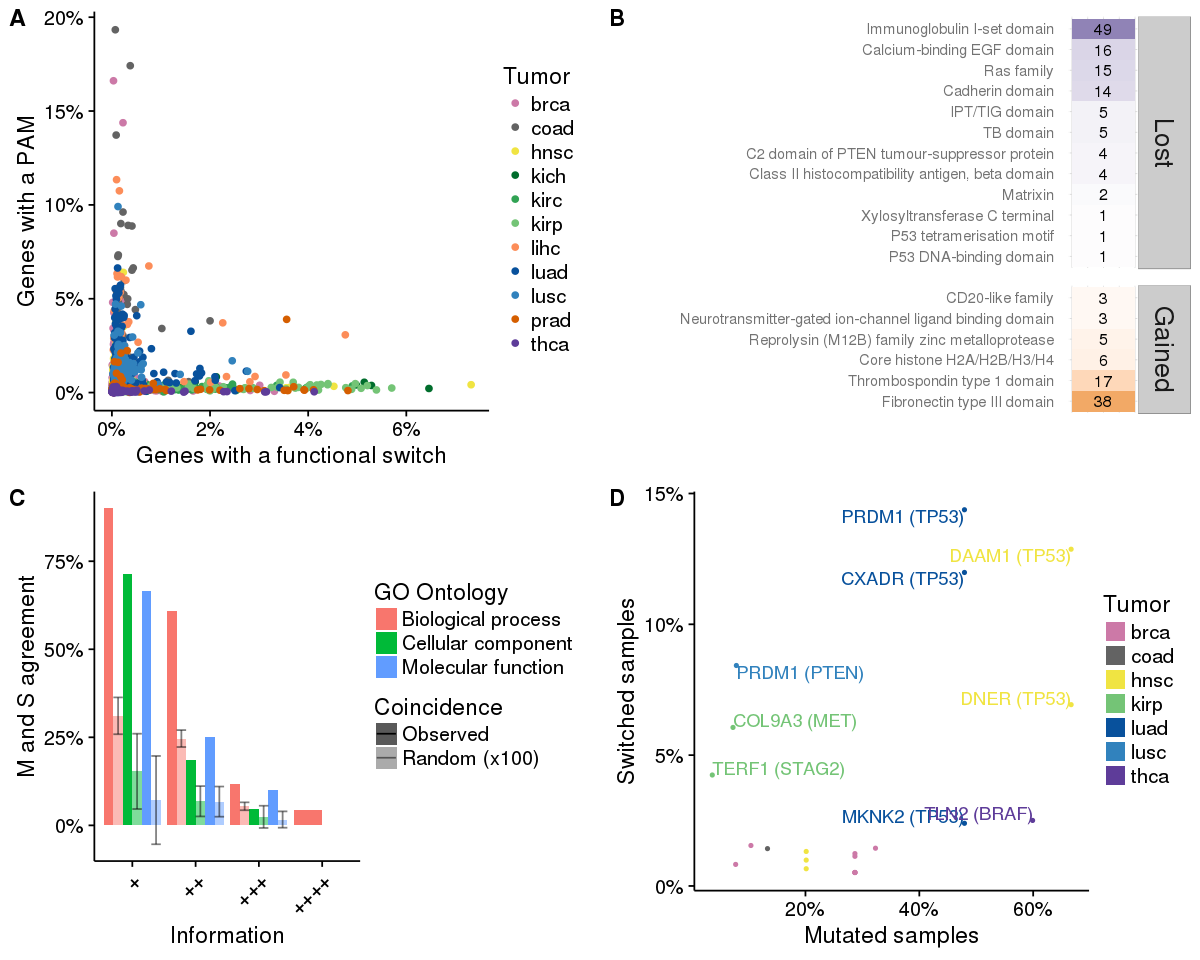

In [11]:
f2 <- plot_grid(f2a, f2b, f2c, f2d, labels=c("A","B","C","D"))
f2
ggsave("../results/figures/figure_2.png",f2, width = 10, height = 8)

**Figure 2.** (A) For each patient sample, colored according to tumor type, we indicate the proportion of all genes with protein affecting mutations (PAMs) in the sample (y axis), and the proportion of genes with multiple transcript isoforms that present a functional isoform switch in the same sample (x axis). (B) Domain classes that are are enriched in losses (left panel) or gains (right panel) in isoform switches that are also enriched in protein-affecting mutations tumors. For each domain class we indicate the number of switches (C) Agreement between protein-affecting mutations and functional switches (y axis) in terms of the functional categories of the protein domains they affect, using 3 different gene ontologies (GO) and at four different GO Slim levels, from most specific (most informative) to the least specific (least informative). Random occurrences were calculated by sampling 100 times the same number of domain classes affected by functional switches or by protein-affecting mutations. (D) Pairs formed by a mutational driver and a functional isoform switch that belong to the same functional pathway and show mutual exclusion of PAMs and switches across patients in at least one tumor type (color coded by tumor type). The graph indicates the percentage of samples where the switch occurs (x axis) and the percentage of samples where the driver is mutated in the same tumor type. Each pair is represented with the gene symbol that has the switch and the mutational driver gene symbol (in parenthesis). 

In [12]:
# Figure 3
# generate oncoprints for all 
# structural_analysis/create_oncoprints.R

**Figure 3.** Protein-protein interactions (PPIs) involving mutational cancer drivers that are affected by switches. **(A)** Switches in tumor-specific driver genes tend to alter interactions more frequently than those in other genes (Fisher’s exact test p-value < 0.02, odds-ratio = 1.37). We divide functional switches according to whether they occur in tumor-specific drivers (HC-driver) or not (Non-driver). In each subset we plot the proportion of PPIs kept intact (gray), lost (red) or gained (green). **(B)** Switches that affect frequently mutated protein features or that are highly recurrent also have a higher proportion of interactions affected compared to the rest of the switches. Functional switches are divided according to whether they are recurrent (Yes) or not (No), or according to whether they affect domains frequently mutated in cancer (M feature) (Yes) or not (No). In each subset we plot the proportion of PPIs kept intact (gray), lost (red) or gained (green). **(C)** The network shows the PPIs of driver XX with its interactors. In <color> we indicate those interactions that are lost by the switches. **(D)** Oncoprint depicting the samples where XX presents protein-affecting mutations or switches, together with the samples where the interactors that affect the PPIs present switches. **(E)** Sames as (C) for the driver YY. **(F)** Oncoprint for YY and interactors that have switches and affect the PPI with YY. 

In [13]:
potus <- switches %>%
    filter(Candidate==1 & Origin=="Tumor") %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

# check that all the patients have at least one switch/mutation
alterationsPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    switchesPerPatient <- plyr::count(patients) %>%
        set_colnames(c("Patient","Switches"))
  
    # read mutations  
    ## get cancer specific drivers
    tumor.drivers <- drivers$Symbol[drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    mutations.drivers <- wes %>%
        filter(Tumor == tumor) %>%
        filter(Symbol %in% tumor.drivers) %>%
        ## consider only mutated genes, not several mutations in a gene
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    mutationsPerPatient <- plyr::count(mutations.drivers$Patient) %>%
        set_colnames(c("Patient","Mutations"))
    
    # get patients with both RNAseq and mutation information
    patients.swt <- unique(patients)
    patients.mut <- unique(wes$Patient)
    patients.common <- intersect(patients.swt,patients.mut)
    
    merge(mutationsPerPatient,switchesPerPatient, all=T) %>%
        mutate(Switches = ifelse(is.na(Switches), 0, Switches/nrow(tumor.potus) ),
               Mutations = ifelse(is.na(Mutations), 0, Mutations/length(tumor.drivers)),
               Tumor = tumor,
               Class = ifelse(Mutations < Switches, "S", "M")) %>%
        filter(Patient %in% patients.common)
  
}) %>% do.call("rbind",.)

png("../results/figures/components/4a.png")
f4a <- switches %>%
    filter(Candidate==1) %>%
    select(Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    mutate(Pannegative = ifelse(Pannegative > 2, 1,0)) %>%
    as.data.frame %>%
    upset(order.by = "freq", nintersects = 15, name.size = 16, line.size = 3, point.size = 8)
dev.off()

pdf 
  2

In [14]:
total <- alterationsPerPatient %>%
    plyr::count('Tumor') %>% 
    set_colnames(c("Tumor","Patients"))

tumorClassification <- alterationsPerPatient %>%
    plyr::count(c('Class','Tumor')) %>%
    set_colnames(c("Class","Tumor","Counts")) %>%
    merge(total) %>%
    mutate(Prop = Counts/Patients, Class = factor(Class, levels=c("S","M")),
           Tumor = factor(Tumor, levels=Tumor[Class=="S"][order(-Prop[Class=="S"])]))

f4b <- ggplot() + 
    geom_bar(data = subset(tumorClassification, Class=="S"),aes(x=Tumor,y=Prop,fill=Tumor),stat="identity") +
    geom_bar(data = subset(tumorClassification, Class=="M"),aes(x=Tumor,y=-Prop,fill=Tumor),stat="identity") +
    geom_text(aes(x=10,y=.85,label="Splicing"), size=5) +
    geom_text(aes(x=2,y=-.85,label="Mutations"), size=5) +
    geom_hline(yintercept = 0) +
    scale_fill_manual(values=colorPalette) +
    labs(y="Patients explained", x="") +
    scale_y_continuous(labels = percent) +
    theme(axis.text.x = element_text(angle = 90))

ggsave("../results/figures/components/4b.png",f4b)

Saving 7 x 7 in image
Warning message:
: Stacking not well defined when ymin != 0

In [15]:
f4c <- ggplot(alterationsPerPatient,aes(x=Switches,y=Mutations,color=Tumor)) + 
    geom_point(size=2) + 
    labs(x="AS-drivers switched",y="Mut-drivers mutated") +
    scale_color_manual(values=colorPalette) +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

ggsave("../results/figures/components/4c.png",f4c)

Saving 7 x 7 in image


Warning message:
: Stacking not well defined when ymin != 0

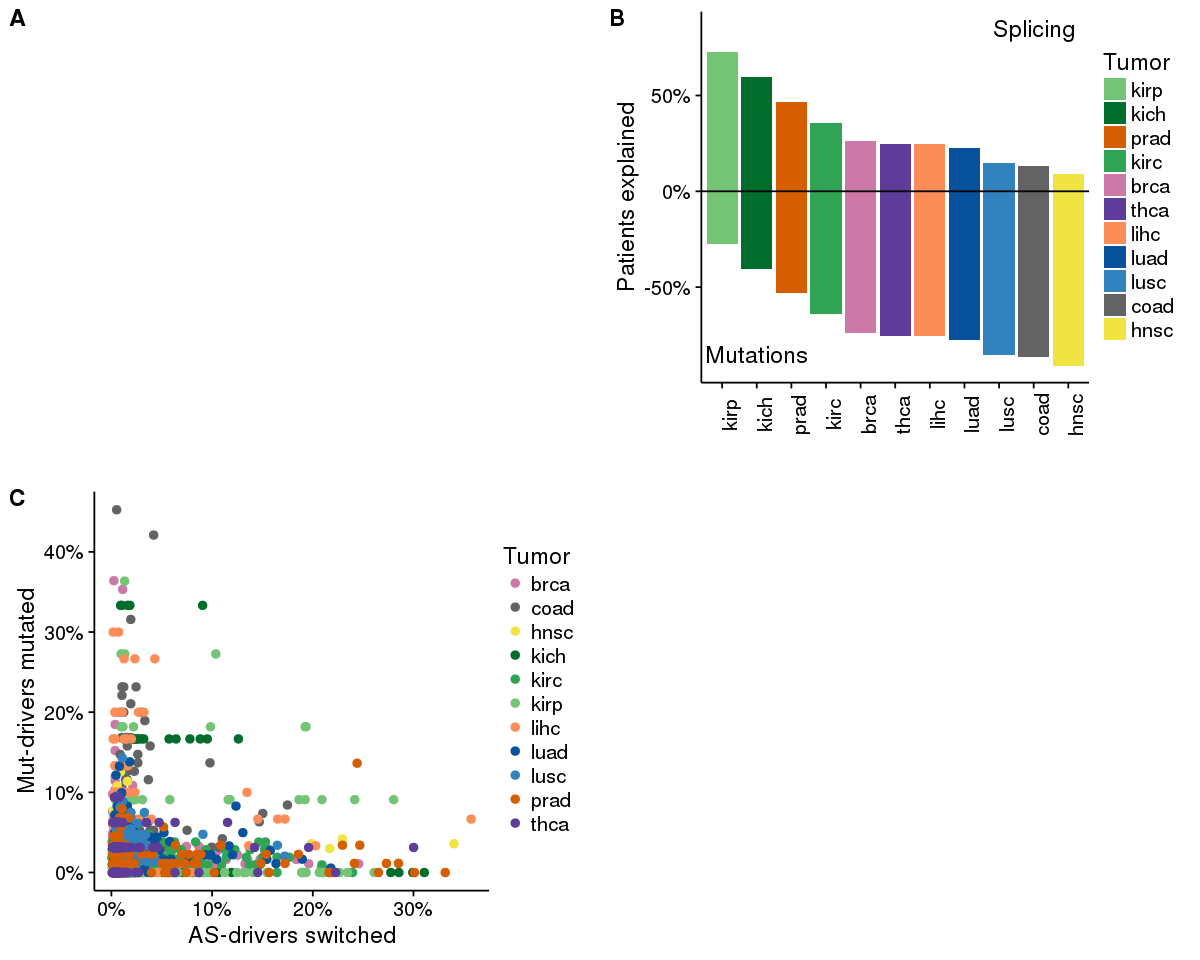

In [16]:
f4 <- cowplot::plot_grid(f4a, f4b, f4c, labels=c("A","B","C"))
f4
ggsave("../results/figures/figure_4.png",f4, width = 10, height = 8)

**Figure 4. (A)** Candidate alternative splicing drivers (AS-drivers) grouped according to their properties: disruption of protein-protein interactions (PPI), recurrence across patients (Methods), gain or loss of a protein feature that is frequently mutated in tumors (affects_mutated_feature), shows mutual exclusion with a Mut-driver in the same pathway (DriverME), and it shows mutual exclusion with a set of drivers  **(B)** Classification of samples according to AS-driver or Mut-driver enrichment in each tumor type. Given the set of tumor specific mutational drivers (Mut-drivers) and our set of pan-cancer switches (AS-drivers) (Supp. Table XX), we represent for each tumor type (x axis) the proportion of samples that have a proportion of mutated Mut-drivers greater than the proportion of switches in AS-drivers (positive y-axis). Similarly, we represent in the negative y-axis the proportion of samples where the proportion of switches in AS-drivers is greater than the proportion of mutated Mut-drivers. **(C)** Every patient sample is represented according to the proportion of mutated Mut-drivers (y-axis) and the proportion of switched AS-drivers (x-axis). The number of sample at a position of the plot range from 0 (white) to XXX (dark blue). 